# Initialization

In [2]:
import tensorflow as tf
import cv2
import glob
import matplotlib.pyplot as plt


In [ ]:
import configs
from ActMapGen import *

# Data Loader

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.filenames = glob.glob(data_dir + '/*/*.jpg')
        self.filenames.sort()
        print(len(self.filenames), 'found')
        self.classnames = ['/akiec/', '/bcc/', '/bkl/',
                           '/df/', '/mel/', '/nv/', '/vasc/']
        self.indices = None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        X, Y = self.__data_generation(filenames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def filename2onehot(self, fn):
        for i in range(configs.NUM_CLASS):
            if self.classnames[i] in fn:
                result = np.zeros(configs.NUM_CLASS, dtype=np.float64)
                result[i] = 1
                return result
        return None

    def __data_generation(self, filenames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y_class = np.empty([num, configs.NUM_CLASS])
        for i, fn in enumerate(filenames):
            img = cv2.imread(fn)
            delta = (configs.IMAGE_SIZE[1] - configs.IMAGE_SIZE[0]) // 2
            img = img[:, delta:configs.IMAGE_SIZE[1]-delta-1]
            img = cv2.resize(img, (224, 224))
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y_class[i] = self.filename2onehot(fn)

        return X, {'out_img':X, 'out_class':Y_class}

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR+'/train', shuffle=False)
val_datagen = MyDataGenerator(configs.DATA_DIR+'/val', shuffle=False)
test_datagen = MyDataGenerator(configs.DATA_DIR+'/test', shuffle=False)

5005 found


In [ ]:
X, Y = train_datagen[0]

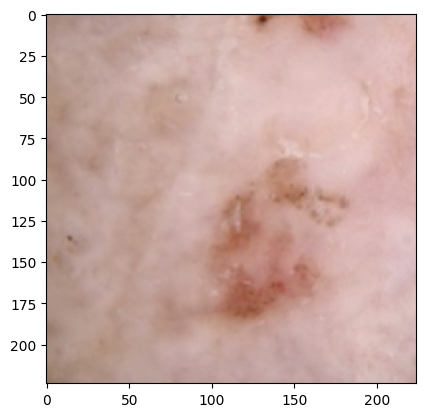

In [ ]:
img = X[0]
plt.imshow(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

# Comparing

In [ ]:
classifier = tf.keras.models.load_model(configs.CLASSIFIER_CHECKPOINT)
generator = tf.keras.models.load_model(configs.CGUNET_CHECKPOINT)

In [ ]:
def compute_confidence_loss(img, label, classifier, activation_map, threshold=0.5):
  activation_map /= activation_map.max()
  mask = np.where(activation_map < threshold, 1, 0)
  mask = np.dstack([mask] * 3)
  img *= mask
  # plt.imshow(cv2.cvtColor((img*255.).astype(np.uint8),
  #                         cv2.COLOR_BGR2RGB))
  # plt.show()
  return classifier.predict(np.array([img]))[0][label]

In [ ]:
print(X.shape, Y.shape)

(32, 224, 224, 3) (32, 7)


In [ ]:
index = 0
img = X[index]
label = Y[index].argmax()
print(img.shape, label)

(224, 224, 3) 5


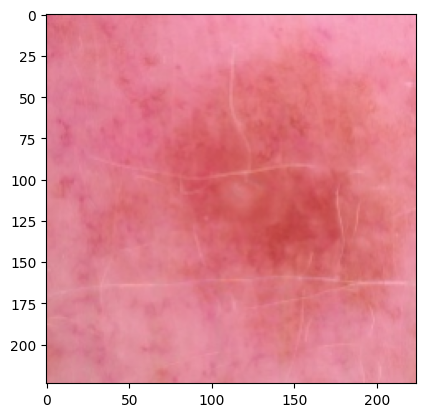

In [ ]:
plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8),
                        cv2.COLOR_BGR2RGB))

In [ ]:
act_map_my = MyActivationMapGen() \
                .generate_activation_map(img, label, classifier, generator)
act_map_px = PixelWiseActivationMapGen() \
                .generate_activation_map(img, label, classifier)
act_map_sppx = SuperPixelActivationMapGen() \
                .generate_activation_map(img, label, classifier, num_segments=128)

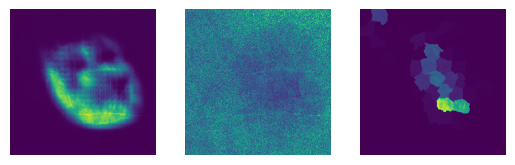

In [ ]:
for i, imap in enumerate([act_map_my, act_map_px, act_map_sppx]):
  plt.subplot(1, 3, i+1)
  plt.axis('off')
  plt.imshow(imap)
plt.show()

In [ ]:
def plots(X, Y, classifier, generator, num_segments=128):
  for index in range(X.shape[0]):
    img = X[index]
    label = Y[index].argmax()

    act_map_my = MyActivationMapGen() \
                .generate_activation_map(img, label, classifier, generator)
    act_map_px = PixelWiseActivationMapGen() \
                .generate_activation_map(img, label, classifier)
    act_map_sppx = SuperPixelActivationMapGen() \
                .generate_activation_map(img, label, classifier, num_segments)

    plt.subplot(1, 4, 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8),
                        cv2.COLOR_BGR2RGB))

    for i, imap in enumerate([act_map_my, act_map_px, act_map_sppx]):
      plt.subplot(1, 4, i+2)
      plt.axis('off')
      plt.imshow(imap)
    plt.tight_layout()
    plt.show()

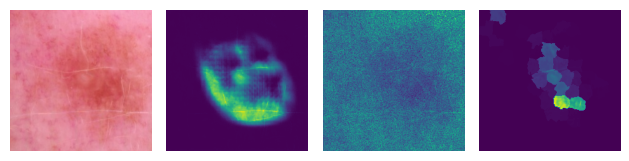

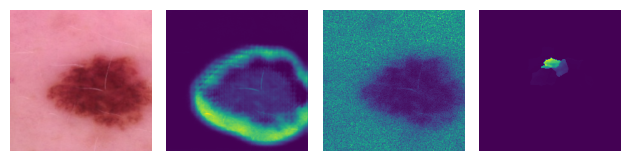

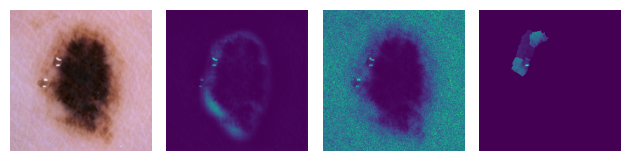

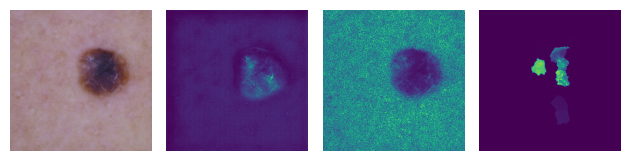

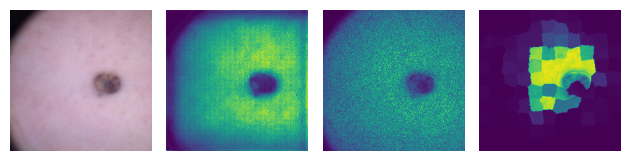

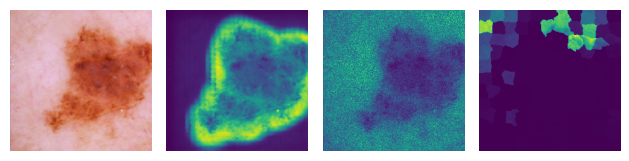

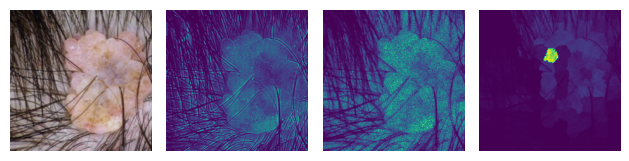

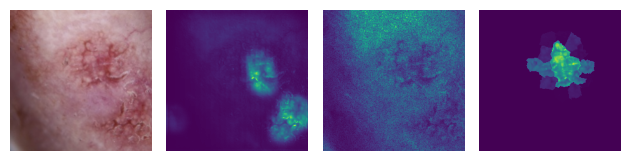

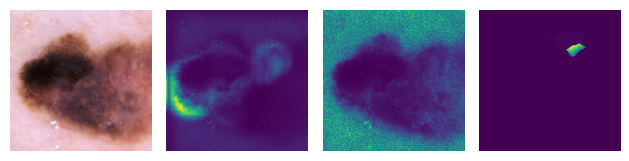

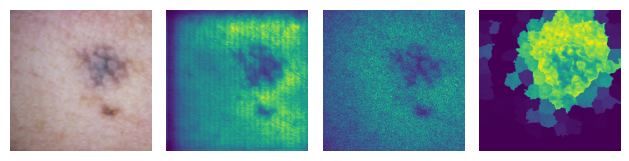

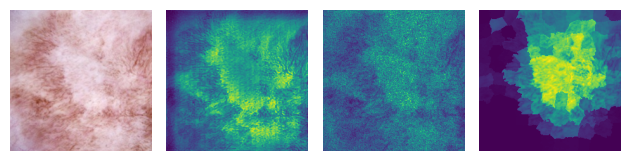

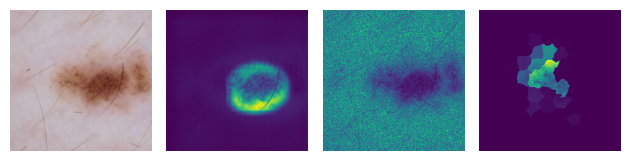

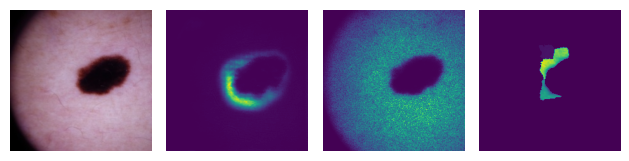

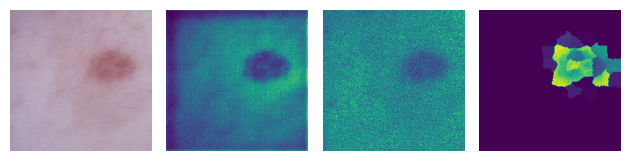

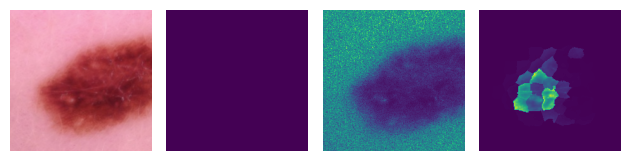

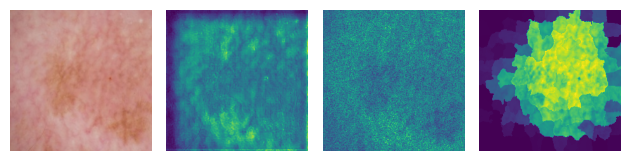

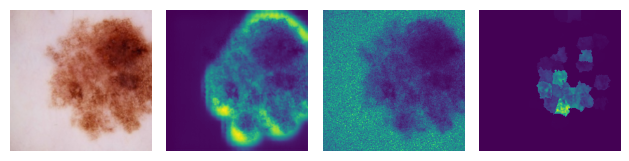

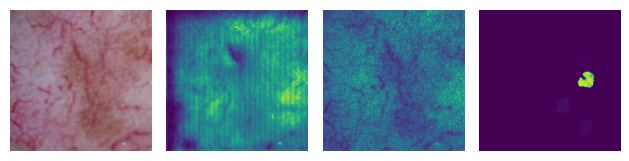

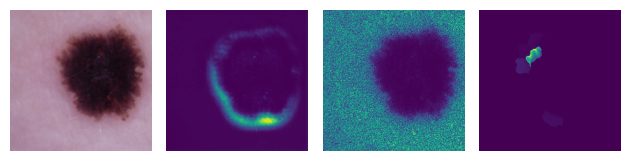

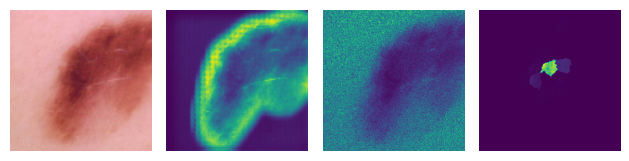

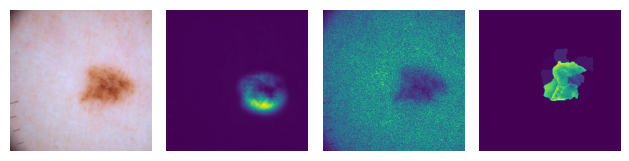

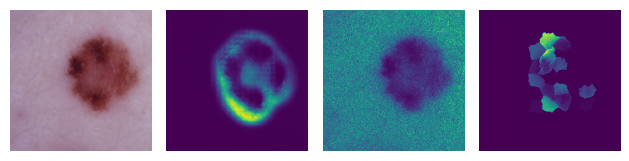

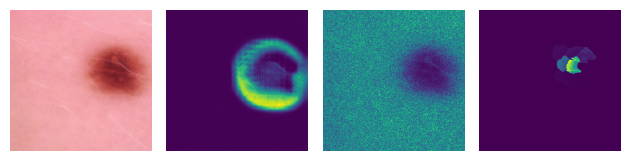

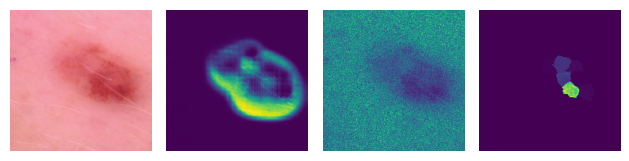

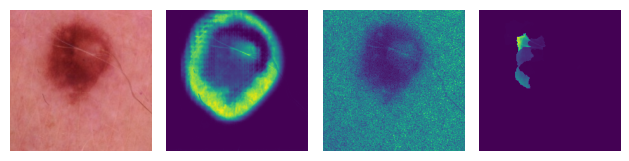

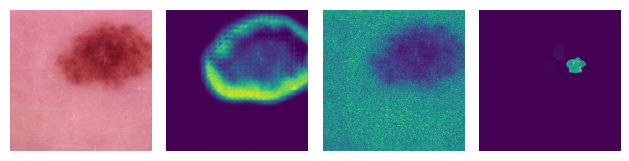

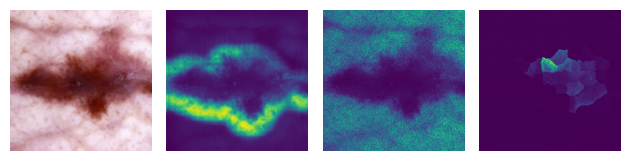

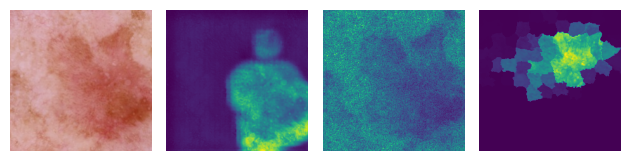

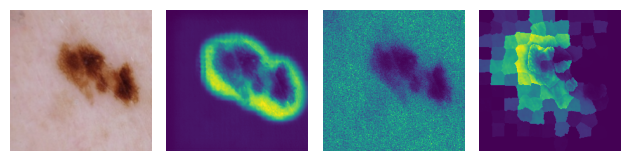

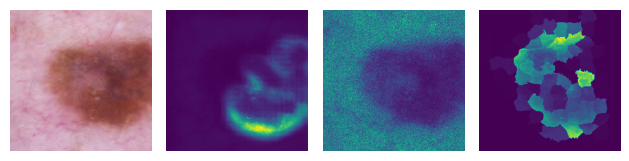

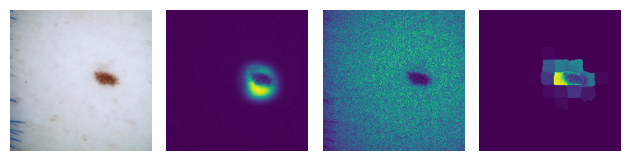

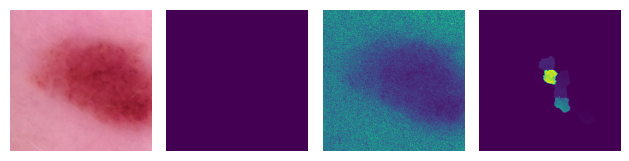

In [ ]:
plots(X, Y, classifier, generator)

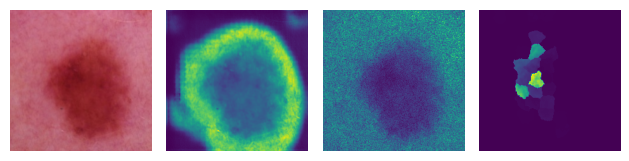

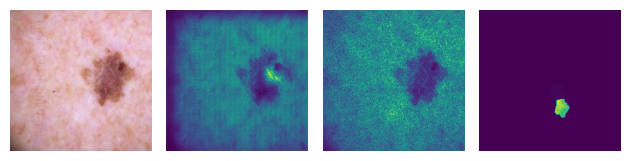

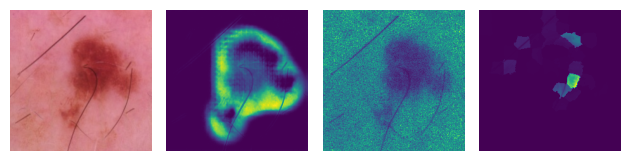

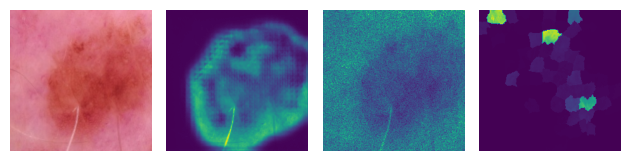

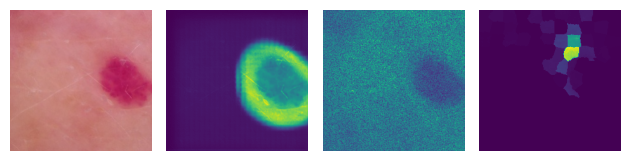

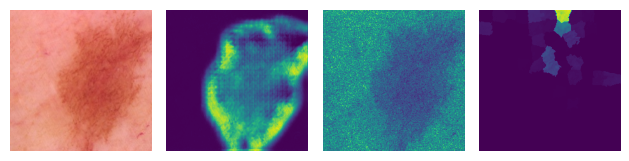

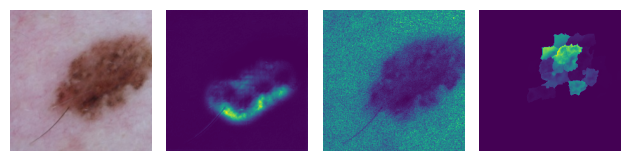

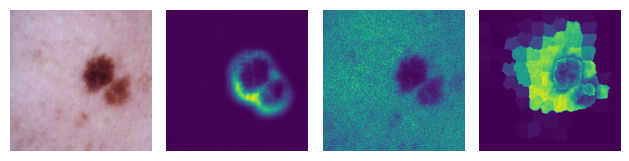

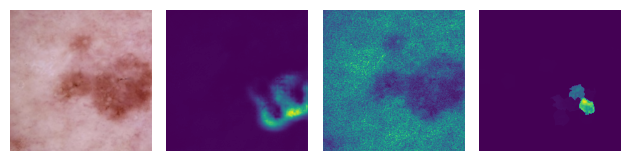

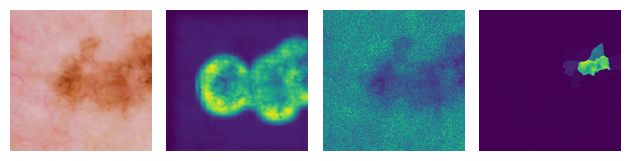

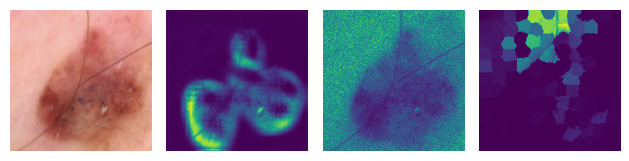

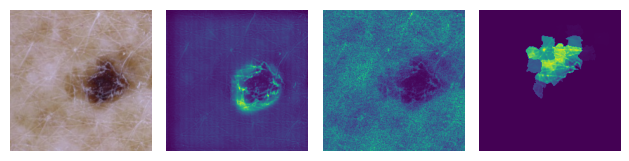

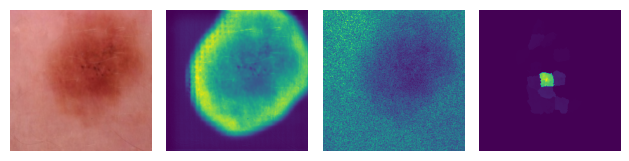

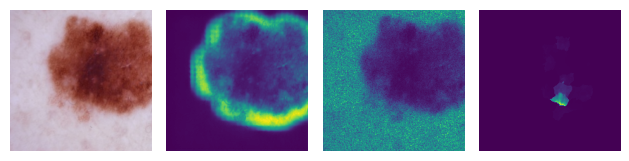

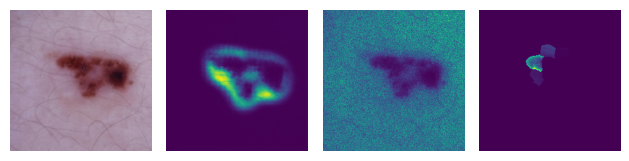

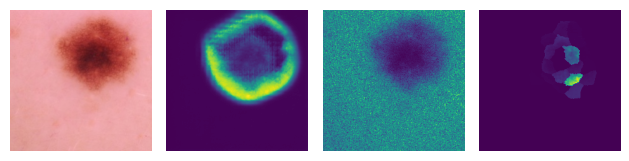

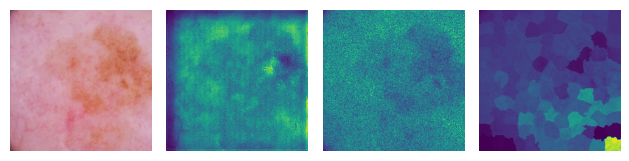

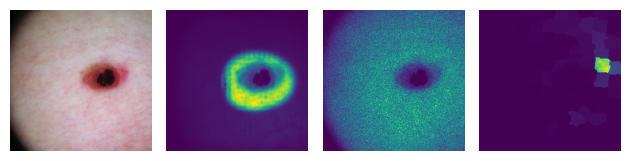

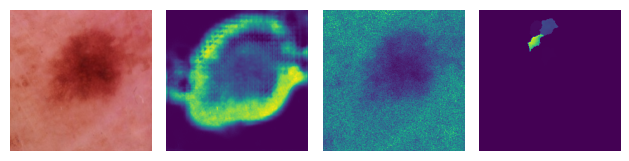

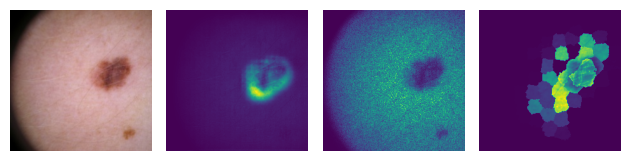

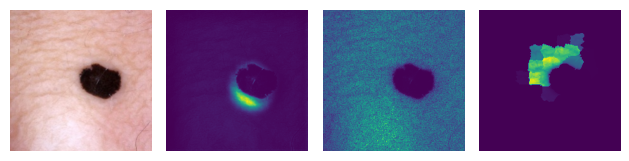

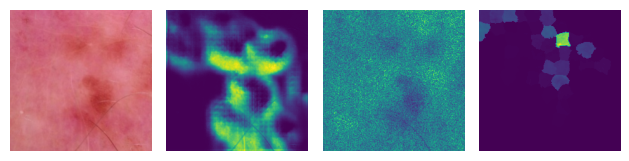

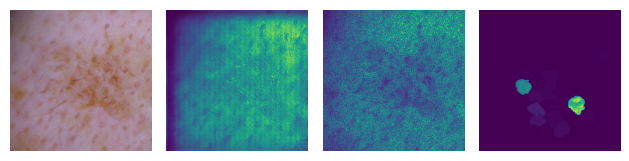

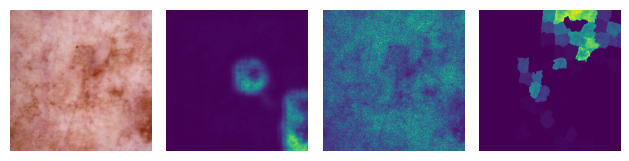

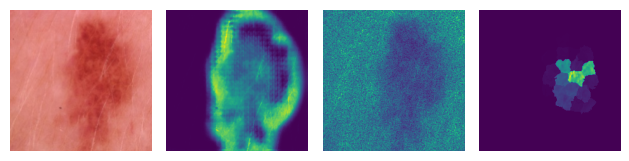

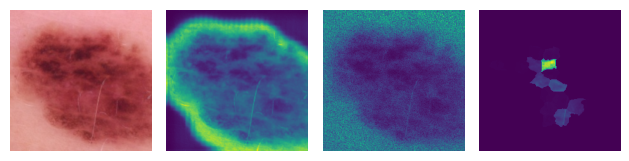

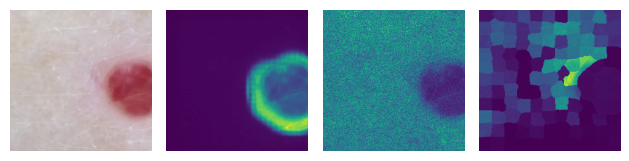

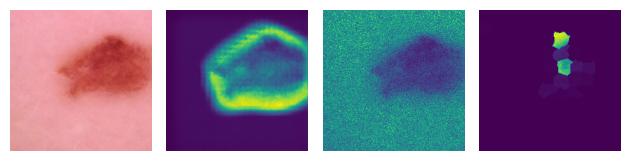

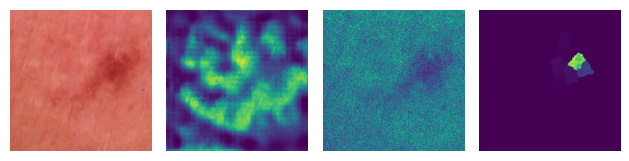

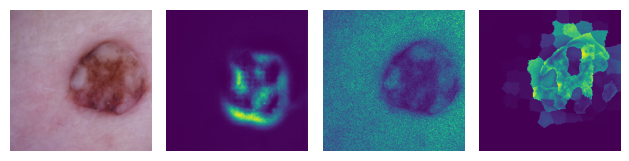

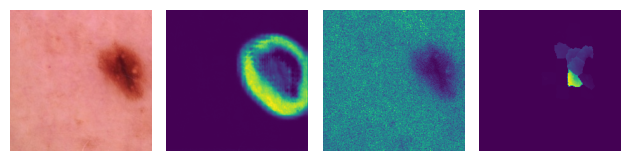

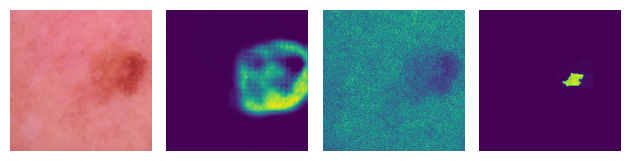

In [ ]:
X, Y = test_datagen[1]
plots(X, Y, classifier, generator)

In [ ]:
compute_confidence_loss(img.copy(), label, classifier, act_map_my, threshold=0.5)

1/1 [==============================] - 0s 33ms/step


0.11470143

In [ ]:
compute_confidence_loss(img.copy(), label, classifier, act_map_px, threshold=0.5)

1/1 [==============================] - 0s 22ms/step


0.1146965

In [ ]:
compute_confidence_loss(img.copy(), label, classifier, act_map_sppx, threshold=0.5)

1/1 [==============================] - 0s 34ms/step


0.11626416

In [ ]:
print(classifier.predict(np.array([img]))[0][label])

1/1 [==============================] - 0s 34ms/step
0.3117905


# AOPC-like metrics

In [ ]:
_myActivationMapGen = MyActivationMapGen()
_pixelWiseActivationMapGen = PixelWiseActivationMapGen()
_superPixelActivationMapGen = SuperPixelActivationMapGen()

def run(img, label, classifier, threshold=0.5):
  act_map_my = _myActivationMapGen \
                .generate_activation_map(img, label, classifier, generator)
  # plt.subplot(2, 3, 1)
  # plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8),
  #                       cv2.COLOR_BGR2RGB))
  # plt.subplot(2, 3, 4)
  # plt.imshow(act_map_my)
  act_map_px = _pixelWiseActivationMapGen \
                  .generate_activation_map(img, label, classifier)
  # plt.subplot(2, 3, 2)
  # plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8),
  #                       cv2.COLOR_BGR2RGB))
  # plt.subplot(2, 3, 5)
  # plt.imshow(act_map_px)
  act_map_sppx = _superPixelActivationMapGen \
                  .generate_activation_map(img, label, classifier, num_segments=128)
  # plt.subplot(2, 3, 3)
  # plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8),
  #                       cv2.COLOR_BGR2RGB))
  # plt.subplot(2, 3, 6)
  # plt.imshow(act_map_sppx)
  # plt.show()

  origin = classifier.predict(np.array([img]), verbose=0)[0][label]
  my = compute_confidence_loss(img.copy(), label, classifier, act_map_my, threshold=0.5)
  px = compute_confidence_loss(img.copy(), label, classifier, act_map_px, threshold=0.5)
  sppx = compute_confidence_loss(img.copy(), label, classifier, act_map_sppx, threshold=0.5)

  return origin, origin-my, origin-px, origin-sppx

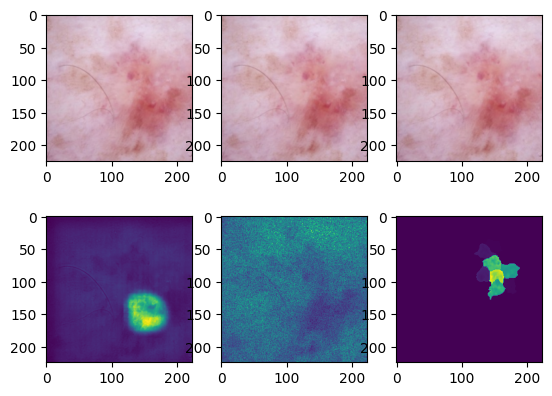

(0.31178665, 0.112488255, 0.19709334, 0.19553484)

In [ ]:
run(img, label, classifier)

In [ ]:
tf.keras.utils.disable_interactive_logging()

target_set = 'test'

filenames = glob.glob(configs.DATA_DIR+'/%s/*/*.jpg'%(target_set))
filenames.sort()
print(len(filenames))

save_filename = confidence_diff_%s.csv'%(target_set)
done_filenames = set([line.strip().split(',')[0] for line in open(save_filename)])
print('done:', len(done_filenames))
filenames = set(filenames).difference(set(done_filenames))
print('doing:', len(filenames))

def get_label(fn):
  classnames = ['/akiec/', '/bcc/', '/bkl/',
                '/df/', '/mel/', '/nv/', '/vasc/']
  for i in range(len(classnames)):
      if classnames[i] in fn:
          return i
  return -1

def load(fn):
  img = cv2.imread(fn)
  delta = (configs.IMAGE_SIZE[1] - configs.IMAGE_SIZE[0]) // 2
  img = img[:, delta:configs.IMAGE_SIZE[1]-delta-1]
  img = cv2.resize(img, (224, 224))
  img = np.array(img, dtype=np.float64) / 255.
  label = get_label(fn)
  return img, label

for fn in filenames:
  img, label = load(fn)
  origin, my, px, sppx = run(img, label, classifier)
  open(save_filename, 'a') \
      .write('%s,%g,%g,%g,%g\n'%(fn,origin, my, px, sppx))
  print(origin, my, px, sppx, fn)

3010
done: 2979
doing: 32
0.31168413 0.19698142 0.19705522 0.19597512 HAM10000/test/akiec/ISIC_0026388.jpg
0.2614263 0.14672482 0.1497938 0.14670046 HAM10000/test/akiec/ISIC_0026466.jpg
0.12188895 0.0069399327 0.007194571 -0.010592386 HAM10000/test/akiec/ISIC_0026522.jpg
0.31178963 0.19498166 0.20482975 0.19699289 HAM10000/test/akiec/ISIC_0024579.jpg
0.3071891 0.19248763 0.1925108 0.19248833 HAM10000/test/akiec/ISIC_0026984.jpg
0.11672826 -0.0012093782 0.0020517036 -0.028655648 HAM10000/test/akiec/ISIC_0025178.jpg
0.15186507 0.034861185 0.03716658 -0.10895693 HAM10000/test/akiec/ISIC_0025411.jpg
0.114200816 -0.000116206706 -0.0003920868 -0.00012522936 HAM10000/test/akiec/ISIC_0025803.jpg
0.12802608 0.013324581 0.013630621 0.013324454 HAM10000/test/akiec/ISIC_0025948.jpg
0.3115053 2.1278858e-05 0.19787863 0.19680423 HAM10000/test/akiec/ISIC_0025182.jpg
0.24452066 0.1298195 0.14820689 0.10871975 HAM10000/test/akiec/ISIC_0027047.jpg
0.31080076 0.1961038 0.20126098 0.19542389 HAM10000/test